In [1]:
import zipfile, os, gc
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from torch import nn, optim
from tqdm import tqdm
import timm

In [2]:
zip_path = '/content/archive (2).zip'  # 🔁 Replace this
extract_path = './dataset'
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Dataset extracted.\n")


✅ Dataset extracted.



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [5]:
train_path = os.path.join(extract_path, 'train')
val_path = os.path.join(extract_path, 'val')
test_path = os.path.join(extract_path, 'test')

train_dataset = ImageFolder('/content/dataset/Data/train', transform=transform)
val_dataset = ImageFolder('/content/dataset/Data/valid', transform=transform)
test_dataset = ImageFolder('/content/dataset/Data/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [6]:
num_classes = len(train_dataset.classes)
model = timm.create_model('deit_base_patch16_224', pretrained=True, num_classes=num_classes)
model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()  # AMP


/tmp/ipython-input-2185087028.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # AMP


In [8]:
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0, 0

    for images, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        preds = outputs.argmax(dim=1)
        running_loss += loss.item() * images.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100 * correct / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # === Validation ===
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1)
            val_loss += loss.item() * images.size(0)
            val_correct += (preds == labels).sum().item()

    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc = 100 * val_correct / len(val_dataset)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    print(f"\n📘 Epoch {epoch+1}/{num_epochs}")
    print(f"Train     Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")
    print(f"Validation Loss: {val_epoch_loss:.4f} | Accuracy: {val_epoch_acc:.2f}%")
    print("-" * 50)

[Epoch 1] Training:   0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipython-input-3176826169.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-3176826169.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 5/5 [00:00<00:00,  8.16it/s]



📘 Epoch 1/10
Train     Loss: 1.0439 | Accuracy: 55.63%
Validation Loss: 1.0878 | Accuracy: 47.22%
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.41it/s]



📘 Epoch 2/10
Train     Loss: 0.5749 | Accuracy: 74.71%
Validation Loss: 0.8970 | Accuracy: 69.44%
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.42it/s]



📘 Epoch 3/10
Train     Loss: 0.2659 | Accuracy: 91.19%
Validation Loss: 0.5965 | Accuracy: 76.39%
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.04it/s]



📘 Epoch 4/10
Train     Loss: 0.1557 | Accuracy: 93.80%
Validation Loss: 1.1033 | Accuracy: 66.67%
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.58it/s]



📘 Epoch 5/10
Train     Loss: 0.0646 | Accuracy: 97.88%
Validation Loss: 0.7761 | Accuracy: 77.78%
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.34it/s]



📘 Epoch 6/10
Train     Loss: 0.0320 | Accuracy: 98.69%
Validation Loss: 0.6564 | Accuracy: 77.78%
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.12it/s]



📘 Epoch 7/10
Train     Loss: 0.1196 | Accuracy: 95.43%
Validation Loss: 0.5482 | Accuracy: 80.56%
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.36it/s]



📘 Epoch 8/10
Train     Loss: 0.0203 | Accuracy: 99.35%
Validation Loss: 1.1779 | Accuracy: 73.61%
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  9.21it/s]



📘 Epoch 9/10
Train     Loss: 0.0753 | Accuracy: 97.06%
Validation Loss: 0.8392 | Accuracy: 77.78%
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.63it/s]


📘 Epoch 10/10
Train     Loss: 0.0283 | Accuracy: 98.86%
Validation Loss: 0.9022 | Accuracy: 79.17%
--------------------------------------------------


/tmp/ipython-input-3142306413.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


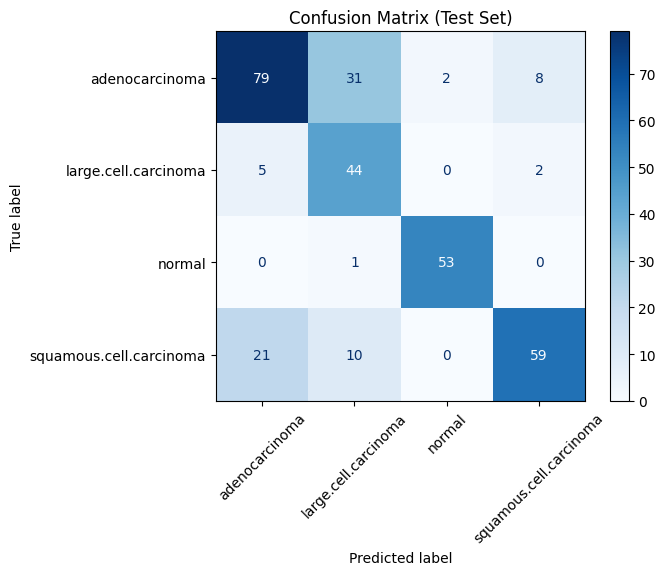

In [9]:
model.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        with torch.cuda.amp.autocast():
            outputs = model(images)
        preds = outputs.argmax(dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.show()


In [10]:
test_acc = accuracy_score(test_labels, test_preds)
print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%")



✅ Test Accuracy: 74.60%
